<a href="https://colab.research.google.com/github/javahedi/project-On-GoogleColab/blob/main/helmholtz_data_challenges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Help a hematologist out Challeng

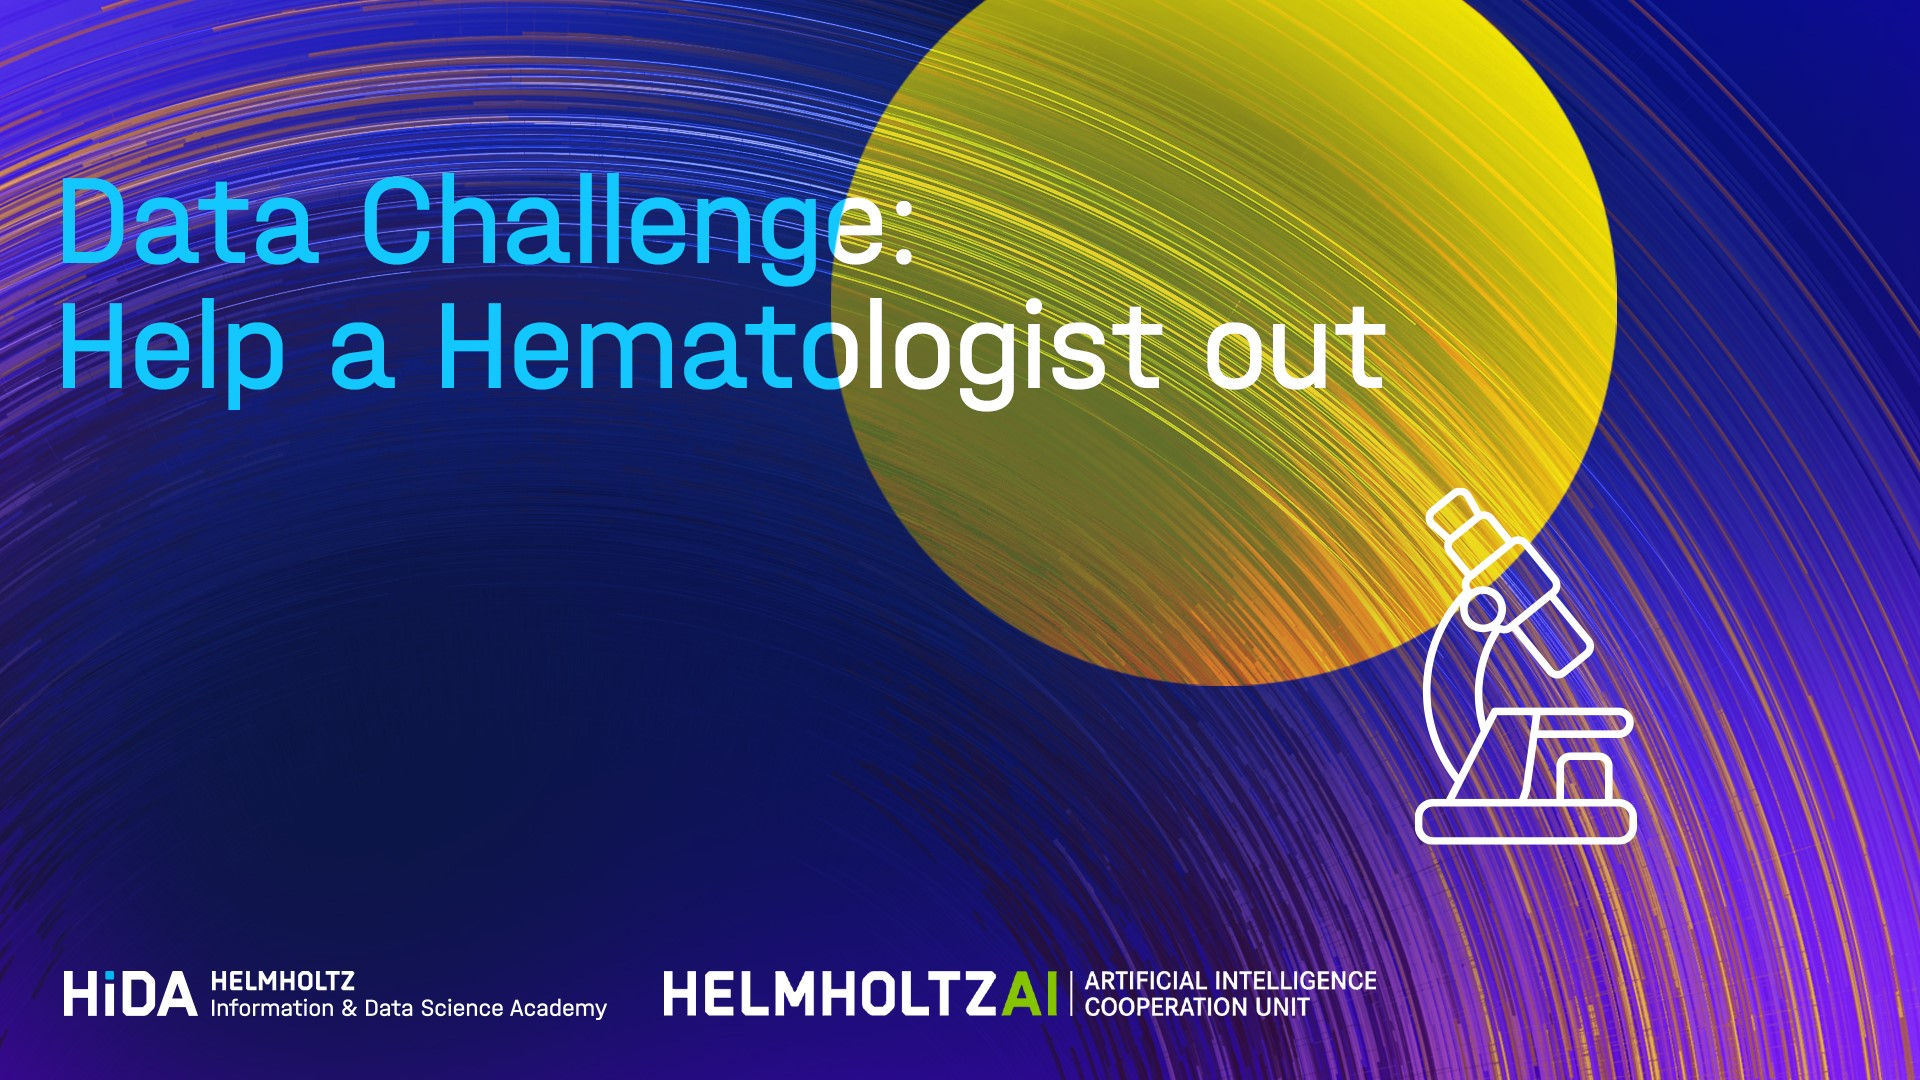

## Challenge Overview
Join us to find elegant domain transfer solutions for blood-cell classification.

Manual classification of blood cells is a tedious, but important task, for instance, to diagnose diseases such as anemia or leukemia. Machine learning makes it easier, but algorithms that work on one set of images might not work on another. Join this challenge and find a solution that may contribute to making clinicians' lives easier.

## Goal

You are given two annotated datasets on single white blood cell images and the goal is to classify the cell type on a third, unseen dataset.

## Data

Two datasets are available for training. We will call the dataset by the name of the first author who published the data. Below you can find a short description and the link to the original papers:

- **Acevedo_20** dataset: the dataset ([Acevedo et al., 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7182702/)) contains a total of 17,092 images of individual normal cells, acquired using the automatic analyzer CellaVision DM96, in the Core Laboratory at the Hospital Clinic of Barcelona. The images were obtained during the period 2015-2019 from blood smears collected from patients without infections, hematologic or oncologic diseases, and free of any pharmacologic treatment at the moment of their blood extraction. The images are in jpg format and the size is 360x363. All the images were obtained in the color space RGB and were annotated by expert clinical pathologists.
- **Matek_19** dataset: the Munich AML Morphology Dataset ([Matek et al., 2019](https://www.nature.com/articles/s42256-019-0101-9)) contains 18,365 expert-labeled single-cell images taken from peripheral blood smears of 100 patients diagnosed with Acute Myeloid Leukemia at Munich University Hospital between 2014 and 2017, as well as 100 patients without signs of hematological malignancy. The images were obtained in the color space RGB and their size is 400x400 pixels.

The goal of this challenge is to achieve high performance, especially a high f1 macro score, on a third dataset, called WBC.

- **WBC1** dataset (validation set): a small subpart of the WBC dataset will be downloadable during phase 1. It is unlabeled and should be used for evaluation and domain adaptation techniques.
- **WBC2** dataset (test set): a second similar subpart of the WBC dataset will become available for download during phase 2 of the challenge, i.e. on the last day, 24 hours before submissions close.

Please note that the organizers performed some transformations on the original datasets to facilitate the analysis specifically for this challenge. The two datasets suitable for training are available at the following [link](https://hmgubox2.helmholtz-muenchen.de/index.php/s/YraZEdrHytaCSza/authenticate/showShare) (password: BgZL3j8DT4). 

A detailed description of the data, together with a model baseline and submission example is available in the notebook in the Presentation materials section on the data challenge event page at this [link](https://events.hifis.net/event/398/contributions/1812/).

Three datasets, each constituting a different domain, will be used for this challenge:
- The Acevedo_20 dataset with labels
- The Matek_19 dataset with labels
- The WBC dataset without labels (Used for domain adaptation and performance measurement)

## Donwloading the data

In [ ]:
!wget --user YraZEdrHytaCSza --password BgZL3j8DT4 https://hmgubox2.helmholtz-muenchen.de/public.php/webdav/Acevedo_20.zip -O Acevedo_20.zip
!wget --user YraZEdrHytaCSza --password BgZL3j8DT4 https://hmgubox2.helmholtz-muenchen.de/public.php/webdav/Matek_19.zip -O Matek_19.zip
!wget --user YraZEdrHytaCSza --password BgZL3j8DT4 https://hmgubox2.helmholtz-muenchen.de/public.php/webdav/WBC1.zip -O WBC1.zip
!wget --user YraZEdrHytaCSza --password BgZL3j8DT4 https://hmgubox2.helmholtz-muenchen.de/public.php/webdav/val_dummy.csv -O val_dummy.csv
!wget --user YraZEdrHytaCSza --password BgZL3j8DT4 https://hmgubox2.helmholtz-muenchen.de/public.php/webdav/metadata2.csv -O metadata2.csv
print('download complete')

In [ ]:
!du -sh *

In [ ]:
! unzip -qq Acevedo_20.zip -d Acevedo_20
! rm -r Acevedo_20.zip

In [ ]:
!unzip -qq WBC1.zip -d WBC1
!rm -r WBC1.zip

In [ ]:
!unzip -qq Matek_19.zip -d Matek_19
!rm -r Matek_19.zip

In [ ]:
!du -sh *

## Exploratory Data Analysis

In [ ]:
# Common classes of the datasets and their labels: 
# Highly underrepresented classes like atypical lymphocytes and smudge cells were left out.

label_map_all = {
        'basophil': 0,
        'eosinophil': 1,
        'erythroblast': 2,
        'myeloblast' : 3,
        'promyelocyte': 4,
        'myelocyte': 5,
        'metamyelocyte': 6,
        'neutrophil_banded': 7,
        'neutrophil_segmented': 8,
        'monocyte': 9,
        'lymphocyte_typical': 10
    }

label_map_reverse = {
        0: 'basophil',
        1: 'eosinophil',
        2: 'erythroblast',
        3: 'myeloblast',
        4: 'promyelocyte',
        5: 'myelocyte',
        6: 'metamyelocyte',
        7: 'neutrophil_banded',
        8: 'neutrophil_segmented',
        9: 'monocyte',
        10: 'lymphocyte_typical'
    }

# The unlabeled WBC dataset gets the classname 'Data-Val' for every image

label_map_pred = {
        'DATA-VAL': 0
    }

## Data visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["savefig.bbox"] = 'tight'

# plot some samples
def plot(imgs, row_title=None, **imshow_kwargs):
      if not isinstance(imgs[0], list):
          # Make a 2d grid even if there's just 1 row
          imgs = [imgs]
      num_rows = len(imgs)
      num_cols = len(imgs[0])
      fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,5), squeeze=False)
      for row_idx, row in enumerate(imgs):
          for col_idx, img in enumerate(row):
              ax = axs[row_idx, col_idx]
              ax.imshow(np.asarray(img), **imshow_kwargs)
              ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

              axs[row_idx, col_idx].set(title=f'{row_title[row_idx]}')
              axs[row_idx, col_idx].title.set_size(10)

      plt.tight_layout()

def call_plot(dataset : str) -> None:

    # collect all folder names inside a directory
    imag_path = [x[0] for x in os.walk(f'/content/{dataset}')]

    # prepare input address for plot function
    imag_path_list=[]
    imag_title_list=[]
    imag_list = []
    for path in imag_path[1:]:
        imag_title_list.append(path.split('/')[-1])
        imag_path_list.append(random.choice(os.listdir(path)))
        imag_list.append(Image.open(f'{path}' + f'/{imag_path_list[-1]}'))

    # call plot function
    plot(imag_list, imag_title_list)

In [ ]:
from PIL import Image
from pathlib import Path
import os, random

### Acevedo_20 data set
- size: 360x363 pixels, 36.0 x 36.3 micrometers
- 10 classes

In [ ]:
call_plot('Acevedo_20')

### Matek_19 data set
- size: 400x400 pixels, 29.0 x 29.0 micrometers
- 11 classes

In [ ]:
call_plot('Matek_19')

### WBC1 data set
- size: 288x288 pixels, 25.0 x 25.0 micrometers
- 11 classes

In [ ]:
call_plot('WBC1')

### Reading **CSV** files
  - ```metadata2.csv```
  - ```val_dummy```

In [ ]:
import pandas as pd

In [ ]:
df_metaata2 = pd.read_csv('metadata2.csv')
df_val = pd.read_csv('val_dummy.csv')

In [ ]:
df_metaata2.head()

In [ ]:
df_val.head()

In [ ]:
import os
from time import sleep
from glob import glob
import random
from tqdm import tqdm
import copy
import ntpath

savepath='metadata.csv' # path where the created dataframe will be stored

def finding_classes(data_dir):
    """
    this function finds the folders in the root path and considers them
    as classes
    """
    classes = [folder for folder in sorted(os.listdir(data_dir)) if not folder.startswith('.') and not folder.startswith('_')]
    return classes


def metadata_generator(data_path):
    #this function generates a pandas dataframe containing image information (paths, labels, dataset)
    metadata = pd.DataFrame(columns=["Image", "file", "label", "dataset", "set"])
    for ds in data_path:
        list_of_classes = finding_classes(data_path[ds])
        for cl in list_of_classes:
            metadata_dummy = pd.DataFrame(columns=["Image", "file", "label", "dataset", "set"])
            metadata_dummy["Image"] = None
            metadata_dummy["file"] = sorted(glob(os.path.join(data_path[ds], cl, "*")))
            metadata_dummy["label"] = cl
            metadata_dummy["dataset"] = ds
            metadata_dummy["set"] = "train"
            for i in range(len(metadata_dummy)):
                metadata_dummy['Image'].loc[i]=ntpath.basename(metadata_dummy['file'][i])
            metadata = metadata.append(metadata_dummy, ignore_index=True)
            metadata_dummy = None
            
    return metadata

In [ ]:
data_path = {
        "Ace_20": "/content/Acevedo_20", # Acevedo_20 Dataset
        "Mat_19": "/content/Matek_19", # Matek_19 Dataset
        "WBC1": "/content/WBC1" # WBC1 dataset
    }

metadata = metadata_generator(data_path)

In [ ]:
metadata.head()

In [ ]:
df_acc=metadata.loc[metadata['dataset']=='Ace_20'].reset_index(drop = True)
df_mat=metadata.loc[metadata['dataset']=='Mat_19'].reset_index(drop = True)
df_wbc=metadata.loc[metadata['dataset']=='WBC1'].reset_index(drop = True)
df_mix=metadata.loc[metadata['dataset']!='WBC1'].reset_index(drop = True)


In [ ]:
df_acc.to_csv('Ace_20.csv') 
df_mat.to_csv('Mat_19.csv') 
df_wbc.to_csv('WBC1.csv')
metadata.to_csv('metadata.csv')

In [ ]:
df_acc.describe(include='all')  

In [ ]:
df_acc.dtypes

In [ ]:
df_mat.describe(include='all')  

In [ ]:
df_wbc.describe(include='all')  

In [ ]:
df_acc['label']

In [ ]:
#for i in range(df_acc.shape[0]):
#    df_acc.loc[i,'label_id'] = int(label_map_all[df_acc.loc[i,'label']])
#df_acc.head()

In [ ]:
from pandas.core.api import DataFrame

def hist_data_plot(name : str, dataset : DataFrame, color='m') -> None:
    # pandas command
    # dataset.label.value_counts()
    hist = {
        'basophil': 0,
        'eosinophil': 0,
        'erythroblast': 0,
        'myeloblast' : 0,
        'promyelocyte': 0,
        'myelocyte': 0,
        'metamyelocyte': 0,
        'neutrophil_banded': 0,
        'neutrophil_segmented': 0,
        'monocyte': 0,
        'lymphocyte_typical': 0
    }

    for i in range(dataset.shape[0]):
        hist[dataset.loc[i,'label']] +=1

    # plot
    
    plt.figure(figsize=(6,4))
    plt.barh(list(hist.keys()), list(hist.values()), color=color)
    plt.title(f'data set : {name}', fontsize = 12)
    plt.show()


In [ ]:
hist_data_plot('Acevedo_20', df_acc)

In [ ]:
hist_data_plot('Matek_19', df_mat, color='g')

❗❗❗ big imbalance  ❗❗❗

In [ ]:
hist_data_plot('full-data', df_mix, color='orange')

In [ ]:
print('\033[1m' + 'label \t \t \timages'+ '\033[0m')
print('')
print(f'total \t \t \t{len(df_mix)}')
df_mix.label.value_counts()

In [ ]:
#shuffle the DataFrame rows & return all rows
#df_mix_shuffel = df_mix.sample(frac = 1).reset_index()
#df_mix_shuffel.head()
## Drop shuffle Index
#df_mix_shuffel = df_mix.sample(frac = 1).reset_index(drop=True)

In [ ]:
df_mix.tail()

In [ ]:
import torch
from PIL import Image
from torchvision import transforms 


class Dataset(torch.utils.data.Dataset):
      'Characterizes a dataset for PyTorch'
      def __init__(self, metadata, dataset, label_map=[], shuffel=True, transform=None):
          # load metadata.csv as panda DataFrame
          df = pd.read_csv(metadata,index_col=False)    
          df = df.loc[df['dataset']== dataset].reset_index(drop = True)

          if shuffel:
              self.data = df.sample(frac = 1).reset_index(drop=True)
          else:
              self.data = df

          self.label_map = label_map
          self.transform = transform
          

      def __len__(self):
          'Denotes the total number of samples'
          return len(self.data)

      def __getitem__(self, idx):
          'Generates one sample of data'

          if torch.is_tensor(idx):
              idx = idx.tolist()


          
          # get image 
          img_path = self.data.loc[idx,"file"]
          image = Image.open(img_path)

          # PIL H,W,C
          image = np.array(image) / 255.
          

          # torch C,H,W
          image = np.transpose(image, (2, 0, 1))
         


          # map numpy array to tensor
          image = torch.from_numpy(copy.deepcopy(image)) 
          image = image.float()
          
          #print(image.shape)



          # if any transform 
          if self.transform:
              image = self.transform(image) 
          
          # get label
          label = self.data.loc[idx,"label"]
          label = self.label_map[label]
          label = torch.tensor(label).long()


          return image.float(), label


lets define a transformation function to use this pipline for augmentation pipline 

In [ ]:
from torch.utils.data import Subset
#import sklearn
#from sklearn.model_selection import train_test_split

def create_data_set(dataset_name : str):

      #dataset_name = "Ace_20" #, "Mat_19", "WBC1"

      tf=transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.CenterCrop([256,256]),
                    transforms.Resize([64,64]),
                    transforms.ToTensor(),
                    ])


      main_dataset = Dataset(metadata='/content/metadata.csv', 
                            dataset=dataset_name, 
                            label_map=label_map_all,
                            shuffel=True,
                            transform=tf)
      


      lenght = len(main_dataset)

      train_indx = int(0.6 * lenght)
      valid_indx = train_indx + int(0.2 * lenght)

      train_dataset = Subset(main_dataset, torch.arange(train_indx)) 
      valid_dataset = Subset(main_dataset, torch.arange(train_indx,valid_indx)) 
      test_dataset  = Subset(main_dataset, torch.arange(valid_indx,lenght)) 
      #print(lenght,len(train_dataset),len(valid_dataset),len(test_dataset))

      print('Train set:', len(train_dataset))
      print('Validation set:', len(valid_dataset))
      print('Test set:', len(test_dataset))


         
      
      return train_dataset, valid_dataset, test_dataset

In [ ]:
dataset = create_data_set("Ace_20")

In [ ]:
fig = plt.figure(figsize=(15,6))
for i in range(len(dataset[0])):
    image,  label =dataset[0][i]  
    ax = plt.subplot(1, 5, i + 1)
    ax.set_title(f'{label_map_reverse[int(label)]}', fontsize=15)
    ax.axis('off')
    #ax.imshow(image)
    ax.imshow(image.permute(1, 2, 0))

    if i == 4:
        plt.show()
        break

In [ ]:
from torch.utils.data import DataLoader

# now create Loader for three datsets

batch_size = 32
torch.manual_seed(1)

train_dl = DataLoader(dataset[0], batch_size, shuffle=True)
valid_dl = DataLoader(dataset[1], batch_size, shuffle=True)
test_dl  = DataLoader(dataset[2], batch_size, shuffle=True)

In [ ]:
fig = plt.figure(figsize=(15, 6))
num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(train_dl))
    label = int(label_batch[0])
    img = img_batch[0]
    ax = fig.add_subplot(1, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{label_map_reverse[label]}', size=15)
    #ax.imshow(img)
    print(img.shape)
    ax.imshow(img.permute(1, 2, 0))



### train a CNN smile classifier
- input image  size $3\times64\times64$
- input goes through 4 cnn layes with 32, 64, 128 and 256 feature
- max-pool (2,2)- two dropout layers for regulaization

### train a CNN smile classifier

- input image  size $3\times64\times64$
- input goes through 4 cnn layes with 32, 64, 128 and 256 feature
- max-pool (2,2)
- two dropout layers for regulaization

In [ ]:
import torch.nn as nn 

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))


model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))


model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))



model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())


In [ ]:
# lets see the shape of feature maps 

x = torch.ones([4, 3, 64, 64])
model(x).shape

- there are 256 feature maps with iamge size $8\times8$
- number of flatten input for fully-connected layer $8\times8\times256=16384$
- let's ad a layer ```global average-pooling```, pooling size is eqaul to the size of feature maps
- computes the average of each feature maps separately, 
- reducing the hidding units to 256

In [ ]:
model.add_module('pool4', nn.AvgPool2d(kernel_size= 8))
model.add_module('flatten', nn.Flatten())

In [ ]:
# lets see the shape of feature maps 

x = torch.ones([4, 3, 64, 64])
model(x).shape

- now, add fully connected layer, to get output unit,
- we specifiy the "sofmax" activation fuction

In [ ]:
model.add_module('fc', nn.Linear(256,11))

In [ ]:
# lets see the shape of feature maps 

x = torch.ones([4, 3, 64, 64])
model(x).shape

In [ ]:
model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) 

 - for multi-classification problem, one usually, use **softmat** activation to obtain class-membership probability
 - However, **softmax** function is already used internally inside PyTorch's ***CrossEntropyLoss*

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## **Adam**:
- is robout optimizer, gradient-based optimization method suited to **nonconvex** optimization and ML problems.
- update step size derived fropm the running average of gradient moments.


Now, let's train out model

In [ ]:
from sklearn.metrics import f1_score , matthews_corrcoef  
   

def train(model, num_epoches, train_dl, valid_dl):
    loss_hist_train       = [0] * num_epoches
    loss_hist_valid       = [0] * num_epoches
    accu_hist_train       = [0] * num_epoches
    accu_hist_valid       = [0] * num_epoches
    f1_hist_train         = [0] * num_epoches
    f1_hist_valid          = [0] * num_epoches
    matthews_hist_train   = [0] * num_epoches
    matthews_hist_valid   = [0] * num_epoches

    for epoch in range(num_epoches):
        model.train()

        for x_batch, y_batch in train_dl:

            
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 


            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step() 
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim = 1) == y_batch).float()

            accu_hist_train[epoch]     += is_correct.sum()
            #f1_score = f1_score(y_batch, pred)
            f1_hist_train[epoch]       +=0#f1_score(y_batch.detach().numpy(), pred.detach().numpy())
            matthews_hist_train[epoch] +=0#matthews_corrcoef(y_batch.detach().numpy(), pred.detach().numpy())


        loss_hist_train[epoch]     /= len(train_dl.dataset)
        accu_hist_train[epoch]     /= len(train_dl.dataset)
        f1_hist_train[epoch]       /= len(train_dl.dataset)
        matthews_hist_train[epoch] /= len(train_dl.dataset)

        

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:


                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 

                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim = 1) == y_batch).float()
                accu_hist_valid[epoch] += is_correct.sum()
                f1_hist_valid[epoch]       +=0#f1_score(y_batch.detach().numpy(), pred.detach().numpy())
                matthews_hist_valid[epoch] +=0#matthews_corrcoef(y_batch.detach().numpy(), pred.detach().numpy())


        loss_hist_valid[epoch]     /= len(train_dl.dataset)
        accu_hist_valid[epoch]     /= len(train_dl.dataset)
        f1_hist_valid[epoch]       /= len(train_dl.dataset)
        matthews_hist_valid[epoch] /= len(train_dl.dataset)
        


        print(f'Epoch {epoch+1:3d}  train_accuracy: '
              f'{accu_hist_train[epoch]:.4f}, val_accuracy: '
              f'{accu_hist_valid[epoch]:.4f}, train_f1: '
              f'{f1_hist_train[epoch]:.4f}, val_f1: '
              f'{f1_hist_valid[epoch]:.4f}'
              )
        
    return loss_hist_train, loss_hist_valid, \
           accu_hist_train, accu_hist_valid, \
           f1_hist_train,   f1_hist_valid


In [ ]:
torch.manual_seed(1)
num_epochs = 2
hist = train(model, num_epochs, train_dl, valid_dl)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score

def train_v2(model, num_epochs, train_dl, valid_dl):

      model_save_path='model' #path where model with best f1_macro should be stored

      #running variables
      epoch=0
      update_frequency=1 # number of batches before viewed acc and loss get updated
      counter=0 #counts batches
      f1_macro_best=0 #minimum f1_macro_score of the validation set for the first model to be saved
      loss_running=0
      acc_running=0
      val_batches=0

      y_pred=torch.tensor([], dtype=int)
      y_true=torch.tensor([], dtype=int)
      y_pred=y_pred.to(device)
      y_true=y_true.to(device)


      #Training

      for epoch in range(0, num_epochs):
          #training
          model.train()
          
          with tqdm(train_dl) as tepoch:   
              for i, data in enumerate(tepoch):
                  tepoch.set_description(f"Epoch {epoch+1}")
                  counter+=1

                  x, y = data
                  x, y = x.to(device), y.to(device)

                  optimizer.zero_grad()

                  out = model(x)
                  loss = loss_fn(out, y)
                  loss.backward()
                  optimizer.step()

                  logits = torch.softmax(out.detach(), dim=1)
                  predictions = logits.argmax(dim=1)
                  acc = accuracy_score(y.cpu(), predictions.cpu())
                  
                  if counter >= update_frequency:
                      tepoch.set_postfix(loss=loss.item(), accuracy=acc.item())
                      counter=0
                      
          #validation       
          model.eval()
          with tqdm(valid_dl) as vepoch: 
              for i, data in enumerate(vepoch):
                  vepoch.set_description(f"Validation {epoch+1}")

                  x, y = data
                  x, y = x.to(device), y.to(device)

                  out = model(x)
                  loss = loss_fn(out, y)
                  
                  logits = torch.softmax(out.detach(), dim=1)
                  predictions = logits.argmax(dim=1)
                  y_pred=torch.cat((y_pred, predictions), 0)
                  y_true=torch.cat((y_true, y), 0)
                  
                  acc = accuracy_score(y_true.cpu(), y_pred.cpu())
                  
                  loss_running+=(loss.item()*len(y))
                  acc_running+=(acc.item()*len(y))
                  val_batches+=len(y)
                  loss_mean=loss_running/val_batches
                  acc_mean=acc_running/val_batches
                  
                  vepoch.set_postfix(loss=loss_mean, accuracy=acc_mean)
                  
              f1_micro=f1_score(y_true.cpu(), y_pred.cpu(), average='micro')
              f1_macro=f1_score(y_true.cpu(), y_pred.cpu(), average='macro')
              print(f'f1_micro: {f1_micro}, f1_macro: {f1_macro}')  
              if f1_macro > f1_macro_best:
                  f1_macro_best=f1_macro
                  torch.save(model.state_dict(), model_save_path)
                  print('model saved')
              
              #reseting running variables
              loss_running=0
              acc_running=0
              val_batches=0
                  
              y_pred=torch.tensor([], dtype=int)
              y_true=torch.tensor([], dtype=int)
              y_pred=y_pred.to(device)
              y_true=y_true.to(device)
                  
              
          
      print('Finished Training')

In [ ]:
torch.manual_seed(1)
num_epochs = 2
train_v2(model, num_epochs, train_dl, valid_dl)

In [ ]:
#loading the model with the highest validation accuracy
model.load_state_dict(torch.load('model'))
print(model)